In [1]:
from synth.synth_architecture import SynthModular
from tqdm import tqdm
from synth.parameters_sampling import ParametersSampler
from synth.synth_constants import synth_constants
import numpy as np
from model.loss.spectral_loss import SpectralLoss
import torch
from prettytable import PrettyTable

int_to_waveform = synth_constants.wave_type_dic_inv

def update_osc_parameters(sampled_parameters, amp, freq, phase, waveform):
    # Manually create a new dictionary, avoiding deepcopy
    new_sampled_parameters = {}
    for key in sampled_parameters:
        new_sampled_parameters[key] = {}
        for inner_key in sampled_parameters[key]:
            if inner_key == 'parameters':
                # For 'parameters', create a new dict and replace relevant values
                new_sampled_parameters[key][inner_key] = sampled_parameters[key][inner_key].copy()
                new_sampled_parameters[key][inner_key]['active'] = torch.tensor([True])
                new_sampled_parameters[key][inner_key]['amp'] = amp
                new_sampled_parameters[key][inner_key]['freq'] = freq
                new_sampled_parameters[key][inner_key]['phase'] = phase
                new_sampled_parameters[key][inner_key]['waveform'] = waveform
            else:
                # For other keys, just copy the value
                new_sampled_parameters[key][inner_key] = sampled_parameters[key][inner_key]
    return new_sampled_parameters

def randomize_osc_params():
    amp = torch.tensor([10 ** np.random.uniform(-2.5, 0)], requires_grad=True)
    freq = torch.tensor([10 ** np.random.uniform(np.log10(30), np.log10(4000))], requires_grad=True)
    phase = torch.tensor([np.random.uniform(0, 2*np.pi)], requires_grad=True)
    waveform = torch.tensor([synth_constants.wave_type_dict[np.random.choice(['sine', 'square', 'sawtooth'])]], dtype=torch.int)
    return amp, freq, phase, waveform

def update_synth_params(synth_obj, sampled_parameters, amp, freq, phase, waveform):
    waveform_str = int_to_waveform[waveform.item()]
    sampled_parameters = update_osc_parameters(sampled_parameters, amp, freq, phase, waveform_str)
    synth_obj.update_cells_from_dict(sampled_parameters)
    return synth_obj

def get_perturbed_freq(predicted_freq, target_freq, epsilon_in_cents):
    freq_ratio = 2 ** (epsilon_in_cents / 1200)
    perturbed_freq = predicted_freq * freq_ratio ** torch.sign(predicted_freq - target_freq)
    perturbed_freq = torch.clamp(perturbed_freq, min=0)
    return perturbed_freq

def generate_signals(synth_obj, sampled_parameters, waveform, n_trials=1000, signal_duration=1, batch_size=1):
    target_signals = []
    predicted_signals = []
    waveform_tensor = torch.tensor([synth_constants.wave_type_dict[waveform]], dtype=torch.int)

    for _ in range(n_trials):
        target_amp, target_freq, target_phase, _ = randomize_osc_params()
        synth_obj = update_synth_params(synth_obj,
                                        sampled_parameters,
                                        target_amp,
                                        target_freq,
                                        target_phase,
                                        waveform_tensor)
        target_signal, _ = synth_obj.generate_signal(signal_duration=signal_duration, batch_size=batch_size)

        predicted_amp, predicted_freq, predicted_phase, _ = randomize_osc_params()
        synth_obj = update_synth_params(synth_obj,
                                        sampled_parameters,
                                        predicted_amp,
                                        predicted_freq,
                                        predicted_phase,
                                        waveform_tensor)
        predicted_signal, _ = synth_obj.generate_signal(signal_duration=signal_duration, batch_size=batch_size)

        target_signals.append(target_signal)
        predicted_signals.append(predicted_signal)

    return target_signals, predicted_signals

def experiment(synth_obj, sampled_parameters, spec_losses, waveforms, epsilons_in_cents, n_trials=1000, signal_duration=1, batch_size=1):
    results = {}

    total_iterations = len(spec_losses) * len(epsilons_in_cents) * len(waveforms)
    pbar = tqdm(total=total_iterations, desc="Running Experiments", dynamic_ncols=True, leave=False)

    for loss_preset in spec_losses:
        results[loss_preset] = {}
        spec_loss = spec_losses[loss_preset]
        for epsilon_in_cents in epsilons_in_cents:
            epsilon_key = f"epsilon_{epsilon_in_cents}"
            results[loss_preset][epsilon_key] = {}
            for waveform in waveforms:
                waveform_tensor = torch.tensor([synth_constants.wave_type_dict[waveform]], dtype=torch.int)
                accuracies = []

                for _ in range(n_trials):
                    target_amp, target_freq, target_phase, _ = randomize_osc_params()
                    synth_obj = update_synth_params(synth_obj,
                                                    sampled_parameters,
                                                    target_amp,
                                                    target_freq,
                                                    target_phase,
                                                    waveform_tensor)
                    target_signal, _ = synth_obj.generate_signal(signal_duration=signal_duration, batch_size=batch_size)

                    predicted_amp, predicted_freq, predicted_phase, _ = randomize_osc_params()
                    synth_obj = update_synth_params(synth_obj,
                                                    sampled_parameters,
                                                    predicted_amp,
                                                    predicted_freq,
                                                    predicted_phase,
                                                    waveform_tensor)
                    predicted_signal, _ = synth_obj.generate_signal(signal_duration=signal_duration, batch_size=batch_size)

                    target_pred_dist, _, _ = spec_loss.call(target_signal, predicted_signal, step=0)

                    if epsilon_in_cents > 0:
                        perturbed_freq = get_perturbed_freq(predicted_freq, target_freq, epsilon_in_cents)

                        synth_obj = update_synth_params(synth_obj,
                                                        sampled_parameters,
                                                        predicted_amp,
                                                        perturbed_freq,
                                                        predicted_phase,
                                                        waveform_tensor)
                        predicted_signal, _ = synth_obj.generate_signal(signal_duration=signal_duration, batch_size=batch_size)

                        target_perturbed_dist, _, _ = spec_loss.call(target_signal, predicted_signal, step=0)
                        accuracies.append(int(target_pred_dist < target_perturbed_dist))
                    else:
                        predicted_freq.backward()
                        is_correct_direction = (predicted_freq.grad.item() > 0) == (target_freq.item() < predicted_freq.item())
                        accuracies.append(int(is_correct_direction))
                        predicted_freq.grad.zero_()

                acc = np.mean(accuracies)
                results[loss_preset][epsilon_key][waveform] = acc

                pbar.update(1)
                pbar.refresh()

    # Close the progress bar
    pbar.close()

    return results

def run(loss_presets, epsilons_in_cents, waveforms, n_trials=1000, signal_duration=1, note_off_time=1):

    synth_obj = SynthModular(chain_name='OSC', synth_constants=synth_constants, device='cuda')
    params_sampler = ParametersSampler(synth_constants)
    sampled_parameters = params_sampler.generate_activations_and_chains(synth_obj.synth_matrix,
                                                                        signal_duration,
                                                                        note_off_time,
                                                                        num_sounds_=1)
    spec_losses = {}
    for loss_preset in loss_presets:
        spec_loss = SpectralLoss(loss_preset=loss_preset, synth_constants=synth_constants, device='cuda')
        spec_losses[loss_preset] = spec_loss

    results = experiment(synth_obj,
                      sampled_parameters,
                      spec_losses,
                      waveforms,
                      epsilons_in_cents,
                      n_trials=n_trials)

    return results

def print_results_table(results, loss_presets, epsilons_in_cents, waveforms):
    table = PrettyTable()

    # Set the field names for the table
    field_names = ["Loss Preset, waveshape \ Epsilon"] + [f"f +/- {epsilon} cents" for epsilon in epsilons_in_cents]
    table.field_names = field_names

    for waveform in waveforms:
        for loss_preset in loss_presets:
            # Create a row for the loss preset and waveform
            row = [f"{loss_preset} | {waveform}"]

            for epsilon_in_cents in epsilons_in_cents:
                # Find the accuracy from the results
                epsilon_key = f"epsilon_{epsilon_in_cents}"
                acc = results[loss_preset][epsilon_key][waveform]

                # Add the accuracy to the row
                row.append(acc)

            # Add the row to the table
            table.add_row(row)

    # Print the table
    print(table)


# Define the list of loss presets and epsilons in cents
# loss_presets = ['magnitude', 'log_magnitude', 'cumsum_time', 'cumsum_freq', 'mss_cumsum_time']
loss_presets = ['mss_magnitude', 'mss_mel_spectrogram_magnitude', 'mss_cumsum_time', 'mss_cumsum_freq', 'mss_mel_spectrogram_cumsum_time', 'mss_mel_spectrogram_cumsum_freq']
# loss_presets = ['spectrogram_magnitude', 'spectrogram_log_magnitude']

epsilons_in_cents = [0, 300, 600]
# epsilons_in_cents = [0, 300]
waveforms = ['sine', 'square', 'sawtooth']
# waveforms = ['sine', 'square']

n_trials = 1000
signal_duration = 4
note_off_time = 4

results = run(loss_presets, epsilons_in_cents, waveforms, n_trials=n_trials, signal_duration=signal_duration, note_off_time=note_off_time)
print_results_table(results, loss_presets, epsilons_in_cents, waveforms)

C:\Users\noamk\PycharmProjects\ai_synth\venv\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1024) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(
C:\Users\noamk\PycharmProjects\ai_synth\venv\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1024) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
C:\Users\noamk\PycharmProjects\ai_synth\venv\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1024) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
C:\Users\noamk\PycharmProjects\ai_synth\venv\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel f

+--------------------------------------------+---------------+-----------------+-----------------+
|      Loss Preset, waveshape \ Epsilon      | f +/- 0 cents | f +/- 300 cents | f +/- 600 cents |
+--------------------------------------------+---------------+-----------------+-----------------+
|            mss_magnitude | sine            |     0.517     |      0.855      |       0.87      |
|    mss_mel_spectrogram_magnitude | sine    |     0.497     |      0.535      |      0.526      |
|           mss_cumsum_time | sine           |     0.491     |      0.848      |      0.863      |
|           mss_cumsum_freq | sine           |     0.495     |      0.687      |      0.735      |
|   mss_mel_spectrogram_cumsum_time | sine   |     0.511     |      0.521      |      0.519      |
|   mss_mel_spectrogram_cumsum_freq | sine   |      0.5      |      0.689      |       0.71      |
|           mss_magnitude | square           |      0.5      |      0.676      |       0.7       |
|   mss_me

ANALYSIS

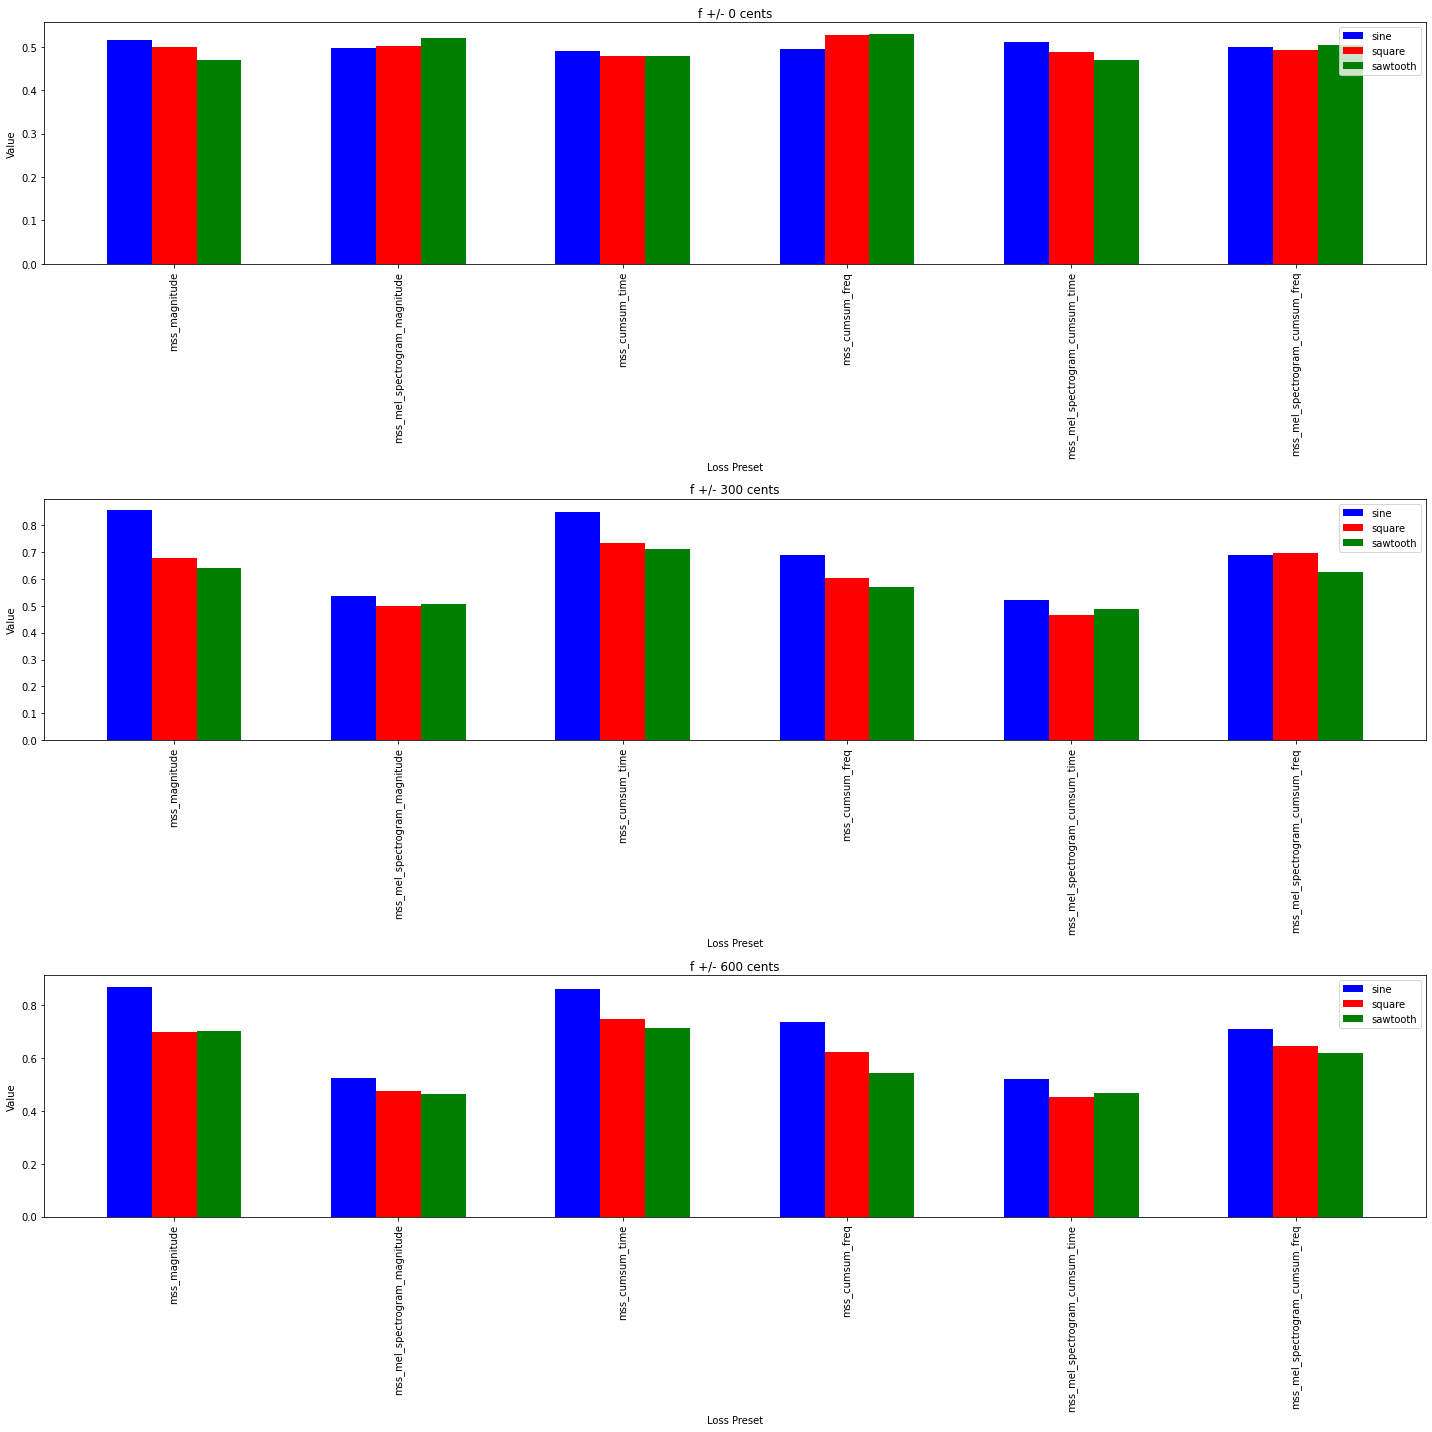

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Recreate the DataFrame
new_data = """
mss_magnitude | sine,0.517,0.855,0.87
mss_mel_spectrogram_magnitude | sine,0.497,0.535,0.526
mss_cumsum_time | sine,0.491,0.848,0.863
mss_cumsum_freq | sine,0.495,0.687,0.735
mss_mel_spectrogram_cumsum_time | sine,0.511,0.521,0.519
mss_mel_spectrogram_cumsum_freq | sine,0.5,0.689,0.71
mss_magnitude | square,0.5,0.676,0.7
mss_mel_spectrogram_magnitude | square,0.501,0.498,0.475
mss_cumsum_time | square,0.48,0.733,0.748
mss_cumsum_freq | square,0.528,0.605,0.623
mss_mel_spectrogram_cumsum_time | square,0.488,0.466,0.452
mss_mel_spectrogram_cumsum_freq | square,0.494,0.696,0.645
mss_magnitude | sawtooth,0.47,0.642,0.701
mss_mel_spectrogram_magnitude | sawtooth,0.52,0.506,0.463
mss_cumsum_time | sawtooth,0.48,0.712,0.715
mss_cumsum_freq | sawtooth,0.53,0.571,0.543
mss_mel_spectrogram_cumsum_time | sawtooth,0.469,0.487,0.467
mss_mel_spectrogram_cumsum_freq | sawtooth,0.505,0.624,0.619
"""

# Split the new data into lines and entries
new_lines = new_data.strip().split("\n")
new_entries = [line.split(",") for line in new_lines]

# Create a new DataFrame with the new data
new_df = pd.DataFrame(new_entries, columns=['Loss Preset, waveshape \\ Epsilon', 'f +/- 0 cents', 'f +/- 300 cents', 'f +/- 600 cents'])

# Convert the numerical columns to float
for column in ['f +/- 0 cents', 'f +/- 300 cents', 'f +/- 600 cents']:
    new_df[column] = new_df[column].astype(float)

# Separate the 'Loss Preset, waveshape \ Epsilon' column into two separate columns
new_df['Loss Preset'] = new_df['Loss Preset, waveshape \\ Epsilon'].apply(lambda x: x.split(' | ')[0])
new_df['Waveshape'] = new_df['Loss Preset, waveshape \\ Epsilon'].apply(lambda x: x.split(' | ')[-1])

# Define a color dictionary for the different waveshapes
color_dict = {
    'sine': 'b',
    'square': 'r',
    'sawtooth': 'g'
}

# Set the figure size
plt.figure(figsize=(20, 20))

# Define the width of the bars and the positions of the groups
bar_width = 0.2
group_positions = np.arange(len(new_df['Loss Preset'].unique()))

# Create subplots for each category
for i, category in enumerate(['f +/- 0 cents', 'f +/- 300 cents', 'f +/- 600 cents'], start=1):
    plt.subplot(3, 1, i)
    for j, waveshape in enumerate(new_df['Waveshape'].unique()):
        # Filter the data for the current waveshape
        waveshape_data = new_df[new_df['Waveshape'] == waveshape]
        # Calculate the positions of the bars for the current waveshape
        bar_positions = group_positions + j * bar_width
        plt.bar(bar_positions, waveshape_data[category], color=color_dict[waveshape], width=bar_width, label=waveshape)
    plt.title(category)
    plt.xlabel('Loss Preset')
    plt.ylabel('Value')
    plt.xticks(group_positions + bar_width, new_df['Loss Preset'].unique(), rotation=90)
    plt.legend(loc='upper right')

# Automatically adjust subplot params so that the subplot fits into the figure area
plt.tight_layout()

# Show the plot
plt.show()


In [1]:
["f +/- " + str(epsilon) + " cents" for epsilon in epsilons_in_cents]

NameError: name 'epsilons_in_cents' is not defined